In [1]:
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['legend.fontsize'] = 14
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 14
%matplotlib inline

# Integrating ideal data

We are going to use IMU readings so we set high sampling period.
Trajectories times are 5 hours.

In [2]:
dt = 0.01 # s
duration = 3600*5 # s
n_samples = int(duration/dt)
step_plot = int(60/dt) # display of one point per min.

## 1. Stationary rotation above Paris

Latitude and longitude of Paris:

In [3]:
lat_Paris = 48.8534 # degrees
lon_Paris = 2.3488  # degrees
alt_Paris = 35      # meters

Set $Cnb = I_{n samplesx3x3}$ :

In [4]:
I3 = np.identity(3) 
Cnb = np.repeat(I3[None,...],n_samples,axis=0)

Set North and east velocities to zeros:

In [5]:
VN = np.zeros(n_samples-1)
VE = np.zeros(n_samples-1)

In [6]:
from pyins import sim

Generate inertial readings:

In [7]:
start_time = time.time()
gyros, accels = sim.stationary_rotation(dt, lat_Paris, alt_Paris, Cnb)
print("--- %.2f seconds ---" % (time.time() - start_time))

--- 18.88 seconds ---


The inertial readings are drawn below

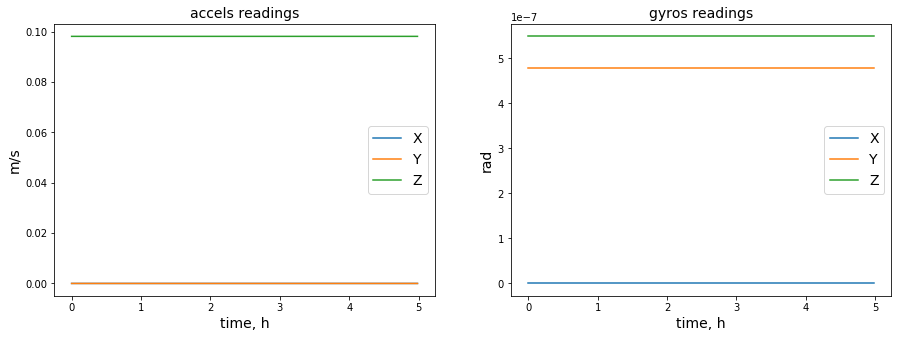

In [8]:
def plot_inertial_readings(dt, gyros, accels, step=1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    n = accels.shape[0]
    t =  dt * np.arange(n)/3600
    
    ax1.plot(t[::step], accels[::step])
    ax1.legend(['X','Y','Z'], loc='center right')
    ax1.set_xlabel('time, h')
    ax1.set_title('accels readings')
    ax1.set_ylabel('m/s')
    
    
    ax2.plot(t[::step], gyros[::step])
    ax2.legend(['X','Y','Z'], loc='center right')
    ax2.set_xlabel('time, h')
    ax2.set_title('gyros readings')
    ax2.set_ylabel('rad')

    plt.show()

plot_inertial_readings(dt, gyros, accels, step_plot)

In [9]:
# A quick test
from pyins import earth 
g = earth.gravity(np.sin(np.deg2rad(lat_Paris)), alt_Paris)
wT = earth.RATE
print(dt*g/accels[0,2]) # the z component of the accels corresponds to gravity
print(dt*wT/np.linalg.norm(gyros[0,:])) # the earth trurn

1.0000001381172956
1.0


#### Integrating IMU data :

In [10]:
from pyins.integrate import coning_sculling, integrate
from pyins.filt import traj_diff

First we apply coning and sculling corrections:

In [11]:
theta, dv = coning_sculling(gyros, accels)

Initial conditions for integration: 

In [12]:
from pyins.dcm import _to_hpr_array, from_hpr

In [13]:
h, p, r = _to_hpr_array(Cnb)

And the run the integration.

In [14]:
start_time = time.time()
traj_ideal = integrate(dt, lat_Paris, lon_Paris, VN[0], VE[0], h[0], p[0], r[0], theta, dv, stamp=0)
print("--- %.2f seconds ---" % (time.time() - start_time))

--- 8.08 seconds ---


#### Error Calculation: 

Creation of data structure for the reference trajectory :

In [15]:
n = accels.shape[0]
traj_ref = pd.DataFrame(index=np.arange(n))
traj_ref['lat'] = lat_Paris*np.ones(n)
traj_ref['lon'] = lon_Paris*np.ones(n)
traj_ref['alt'] = alt_Paris*np.ones(n)
traj_ref['VE'] = VN
traj_ref['VN'] = VE
traj_ref['VU'] = VE 
traj_ref['h'] = h[1:]
traj_ref['p'] = p[1:]
traj_ref['r'] = r[1:]


In [16]:
from pyins.filt import traj_diff

Compute integration error using a convenience function:

In [17]:
err = traj_diff(traj_ideal, traj_ref)

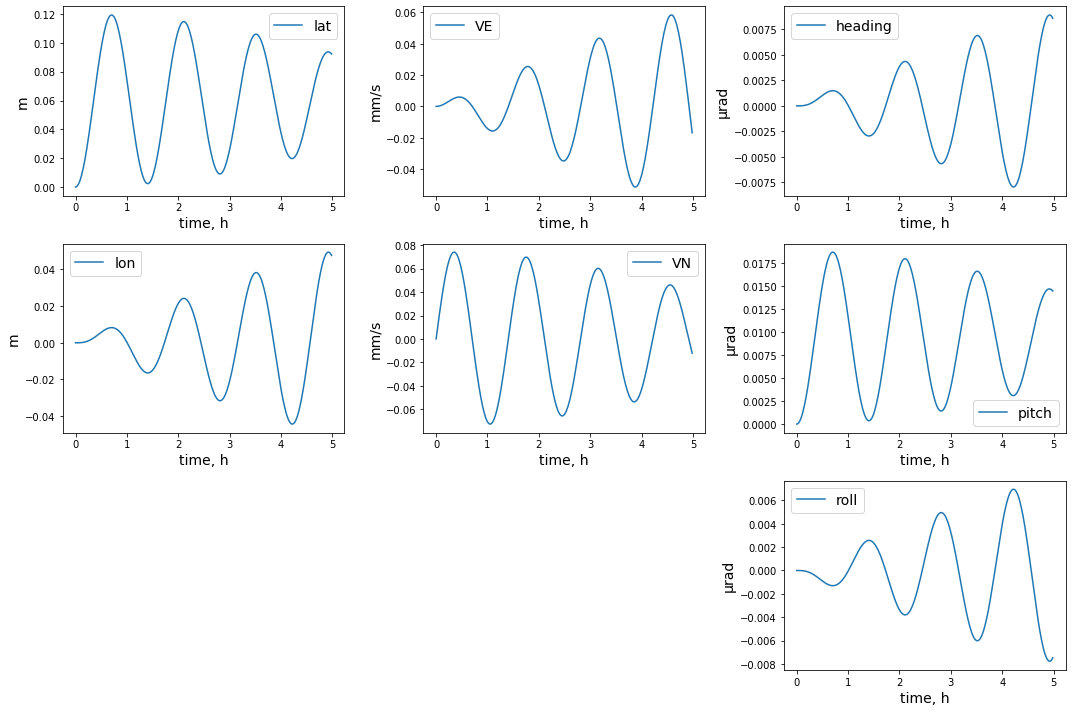

In [18]:
def plot_errors(dt, err, step=1):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(331)
    err = err.iloc[::step]
    
    t = err.index * dt / 3600
    
    plt.plot(t, err.lat, label='lat')
    plt.xlabel("time, h")
    plt.ylabel("m")
    plt.legend(loc='best')
    
    plt.subplot(334)
    plt.plot(t, err.lon, label='lon')
    plt.xlabel("time, h")
    plt.ylabel("m")
    plt.legend(loc='best')
    
    plt.subplot(332)
    plt.plot(t, err.VE*1000, label='VE')
    plt.xlabel("time, h")
    plt.ylabel("mm/s")
    plt.legend(loc='best')
    
    plt.subplot(335)
    plt.plot(t, err.VN*1000, label='VN')
    plt.xlabel("time, h")
    plt.ylabel("mm/s")
    plt.legend(loc='best')

    plt.subplot(333)
    plt.plot(t, np.deg2rad(err.h)*1e6, label='heading')
    plt.xlabel("time, h")
    plt.ylabel("µrad")
    plt.legend(loc='best')
    
    plt.subplot(336)
    plt.plot(t, np.deg2rad(err.p)*1e6, label='pitch')
    plt.xlabel("time, h")
    plt.ylabel("µrad")
    plt.legend(loc='best')
    
    plt.subplot(339)
    plt.plot(t, np.deg2rad(err.r)*1e6, label='roll')
    plt.xlabel("time, h")
    plt.ylabel("µrad")
    plt.legend(loc='best')
    
    plt.tight_layout()
    
plot_errors(dt, err, step_plot)

## 2. Straight line trajectory from Paris

We will use a straight and level flight as a trajectory.

We specify the trajectory with time series of latitudes and longitudes and corresponding time stamps.

In [19]:
lat = np.tile(lat_Paris , n_samples)
lon = np.linspace(lon_Paris, lon_Paris + 35, n_samples)
alt = np.tile(3500, n_samples)
h = np.tile(0, n_samples)
p = np.tile(0, n_samples)
r = np.tile(0, n_samples)

In [20]:
start_time = time.time()
traj_ref, gyros, accels = sim.from_position(dt, lat, lon, alt, h, p, r)
print("--- %.2f seconds ---" % (time.time() - start_time))

--- 18.66 seconds ---


In [21]:
# Quick tests
g = earth.gravity(np.sin(np.deg2rad(traj_ref.lat[0])), alt_Paris)
print(dt*g/accels[0,2]) # the U component of the accels corresponds to gravity

1.0028154921589723


On the plots we see that the velocity as well as the heading are constant.

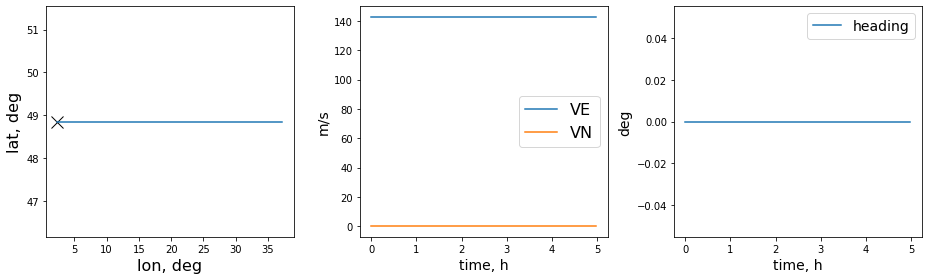

In [22]:
def plot_traj(dt, traj, step=1):
    traj = traj.iloc[::step]
    
    plt.figure(figsize=(13, 4))

    plt.subplot(131)
    plt.plot(traj.lon[0], traj.lat[0], 'kx', markersize=12)
    plt.plot(traj.lon, traj.lat)
    plt.ylabel("lat, deg", fontsize=16)
    plt.xlabel("lon, deg", fontsize=16)

    plt.subplot(132)
    plt.plot(traj.index * dt / 3600, traj.VE, label='VE')
    plt.plot(traj.index * dt / 3600, traj.VN, label='VN')
    plt.xlabel("time, h")
    plt.ylabel("m/s")
    plt.legend(fontsize=16, loc='center right')

    plt.subplot(133)
    plt.plot(traj.index * dt / 3600, traj.h, label='heading')
    plt.xlabel("time, h")
    plt.ylabel("deg")
    plt.legend(loc='best')

    plt.tight_layout()
    
plot_traj(dt, traj_ref, step_plot)

The inertial readings are drawn below:

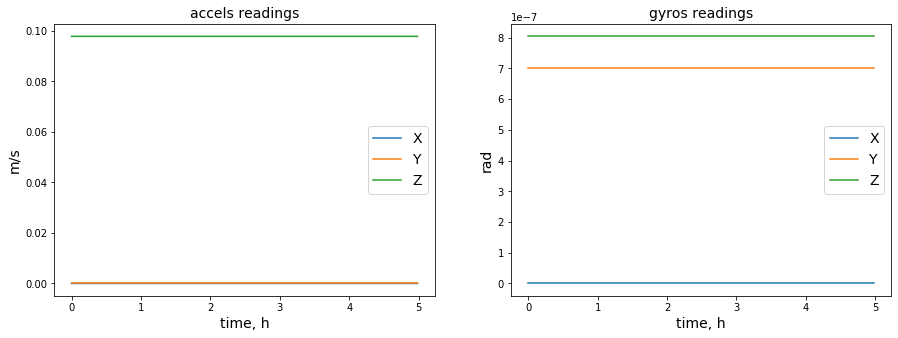

In [23]:
plot_inertial_readings(dt, gyros, accels, step_plot)

Integrating IMU data:

First we apply coning and sculling corrections:

In [24]:
theta, dv = coning_sculling(gyros, accels)

And the run the integration.

In [25]:
start_time = time.time()
traj_ideal = integrate(dt, traj_ref.lat[0], traj_ref.lon[0],
                           traj_ref.VE[0], traj_ref.VN[0],
                           traj_ref.h[0], traj_ref.p[0], traj_ref.r[0],
                           theta, dv, stamp=0)
print("--- %.2f seconds ---" % (time.time() - start_time))

--- 8.13 seconds ---


Compute and plot integration error using a convenience function:

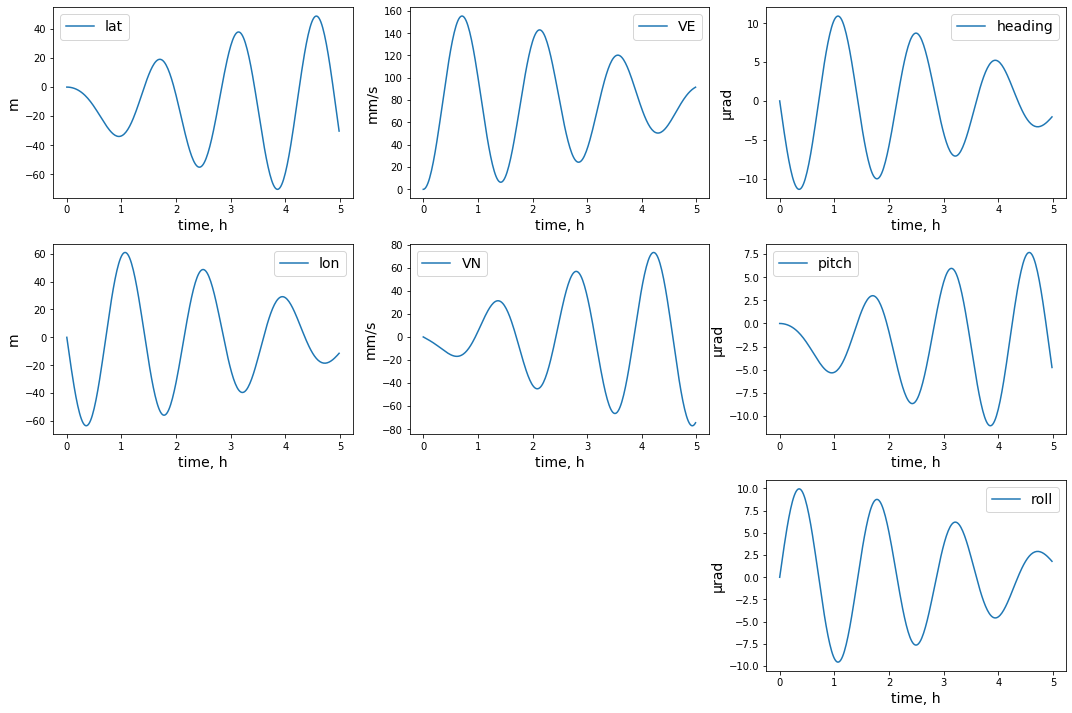

In [26]:
err = traj_diff(traj_ref, traj_ideal)
plot_errors(dt, err, step_plot)

## 3. Random walk trajectory from Paris

We generate sort of a random walk trajectory by summing random displacements.

In [27]:
from pyins.coord import perturb_ll

In [28]:
def generate_trajectory(n_points, min_step, max_step, angle_spread, random_state=0):
    rng = np.random.RandomState(random_state)
    
    xy = [np.zeros(2)]
    angle = rng.uniform(2 * np.pi)
    heading = [90 - angle]
    angle_spread = np.deg2rad(angle_spread)
    for i in range(n_points - 1):
        step = rng.uniform(min_step, max_step)
        xy.append(xy[-1] + step * np.array([np.cos(angle), np.sin(angle)]))
        angle += rng.uniform(-angle_spread, angle_spread)
        heading.append(90 - angle)
    
    return np.asarray(xy), np.asarray(heading)

In [29]:
start_time = time.time()
xy, h = generate_trajectory(n_samples, 0, 0.1, 0.2, random_state=1)
print("--- %.2f seconds ---" % (time.time() - start_time))

--- 26.36 seconds ---


Add displacements to initial latitude and longitude:

In [30]:
lat, lon = perturb_ll(lat_Paris, lon_Paris, xy[:, 1], xy[:, 0])

Set pitch and roll angles to zeros:

In [31]:
p = np.zeros_like(h)
r = np.zeros_like(h)

Run the simulation routine which will interpolate the trajectory and generate inertial readings:

In [32]:
start_time = time.time()
traj_ref, gyros, accels = sim.from_position(dt, lat, lon, alt, h, p, r)
print("--- %.2f seconds ---" % (time.time() - start_time))

--- 25.51 seconds ---


The final trajectory is drawn below, the initial point is marked with a cross.

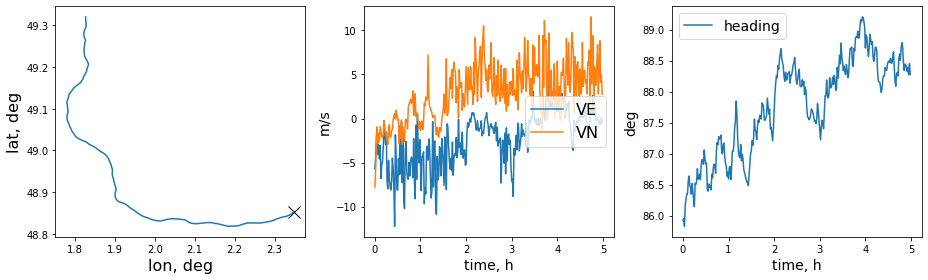

In [33]:
plot_traj(dt, traj_ref, step_plot)

The inertial readings are drawn below:

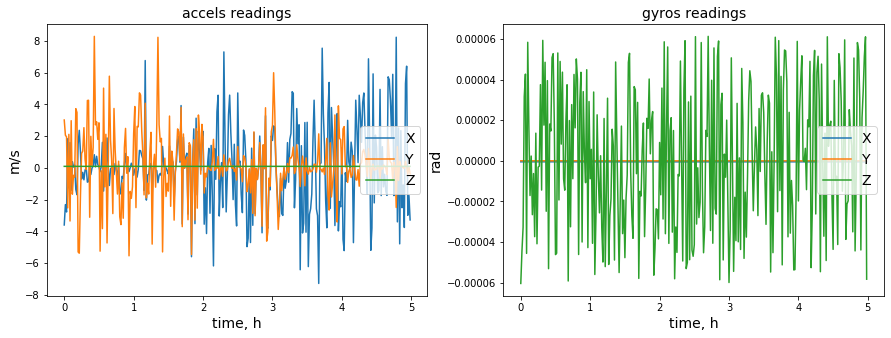

In [34]:
plot_inertial_readings(dt, gyros, accels, step_plot)

Integrating IMU data:

First we apply coning and sculling corrections:

In [35]:
theta, dv = coning_sculling(gyros, accels)

And the run the integration.

In [36]:
start_time = time.time()
traj_ideal = integrate(dt, traj_ref.lat[0], traj_ref.lon[0],
                           traj_ref.VE[0], traj_ref.VN[0],
                           traj_ref.h[0], traj_ref.p[0], traj_ref.r[0],
                           theta, dv, stamp=0)
print("--- %.2f seconds ---" % (time.time() - start_time))

--- 8.62 seconds ---


Compute and plot integration error using a convenience function:

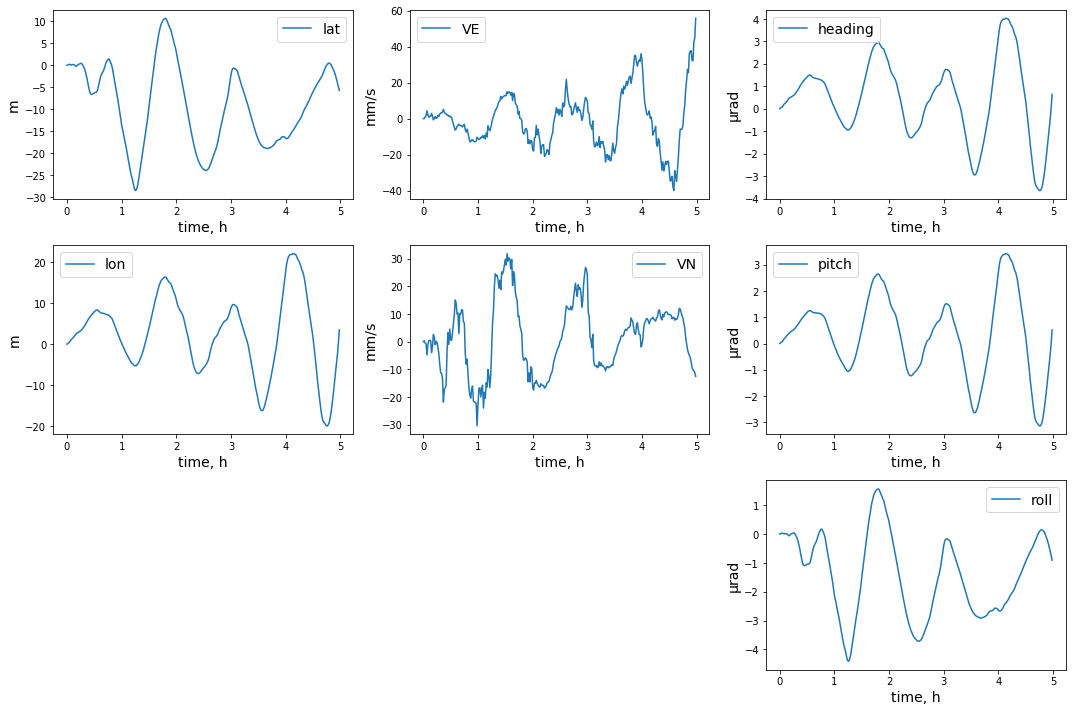

In [37]:
err = traj_diff(traj_ref, traj_ideal)
plot_errors(dt, err, step_plot)